<a href="https://colab.research.google.com/github/MSHQD/HWR/blob/main/Full_text_recognition_mmdetection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# import sys
# print("version:", sys.version)

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# !pip install torch==2.1.0 torchvision==0.16.0 torchaudio==2.1.0 --index-url https://download.pytorch.org/whl/cu121

In [4]:
import cv2
import albumentations as A
import random
import json
from PIL import Image
import os
from torch.utils.data import Dataset, DataLoader
import torch, torchvision
import warnings
import sys
from skimage import io
import numpy as np
import pandas as pd
from tqdm.notebook import tqdm

warnings.filterwarnings("ignore")
import ipywidgets as widgets
from ipywidgets import interact, interact_manual
import shutil
from tqdm import tqdm
from matplotlib import pyplot as plt
import torch.optim as optim
import torchvision
import collections
from torchvision import datasets, models, transforms


/usr/local/lib/python3.11/dist-packages/albumentations/__init__.py:28: UserWarning: A new version of Albumentations is available: '2.0.7' (you have '2.0.6'). Upgrade using: pip install -U albumentations. To disable automatic update checks, set the environment variable NO_ALBUMENTATIONS_UPDATE to 1.
  check_for_updates()


In [5]:
import torch
from torch import nn

# If there's a GPU available...
if torch.cuda.is_available():

    # Tell PyTorch to use the GPU.
    device = torch.device("cuda")

    print('There are %d GPU(s) available.' % torch.cuda.device_count())

    print('We will use the GPU:', torch.cuda.get_device_name(0))

# If not...
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")

There are 1 GPU(s) available.
We will use the GPU: Tesla T4


In [6]:
import zipfile
zip1 = '/content/drive/MyDrive/train_recognition.zip'
extract_to1 = '/content/train_recognition'

with zipfile.ZipFile(zip1, 'r') as zip_ref:
    zip_ref.extractall(extract_to1)

zip2 = '/content/drive/MyDrive/train_segmentation.zip'
extract_to2 = '/content/train_segmentation'
with zipfile.ZipFile(zip2, 'r') as zip_ref:
    zip_ref.extractall(extract_to2)


In [7]:
project_dir = '/content'
data_dir = 'train_recognition'
# train_images = 'images'
train_images = '/content/train_recognition/train_recognition/images'
image_size = 256
first_size = 512

# Settings

In [8]:
!git clone https://github.com/open-mmlab/mmdetection.git
!pip install -e mmdetection

Cloning into 'mmdetection'...
remote: Enumerating objects: 38023, done.
remote: Total 38023 (delta 0), reused 0 (delta 0), pack-reused 38023 (from 1)
Receiving objects: 100% (38023/38023), 63.25 MiB | 29.18 MiB/s, done.
Resolving deltas: 100% (26223/26223), done.
Obtaining file:///content/mmdetection
  Preparing metadata (setup.py) ... done
  Running setup.py develop for mmdet


In [9]:
!git clone https://bitbucket.org/william_rusnack/minimumboundingbox.git
sys.path.append('minimumboundingbox')

Cloning into 'minimumboundingbox'...
Receiving objects: 100% (55/55), 14.57 KiB | 14.57 MiB/s, done.
Resolving deltas: 100% (27/27), done.


In [10]:
!pip install transformers -q
# !pip install transformers==4.28.1
!pip install -q datasets jiwer
!pip install sentencepiece -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.1/3.1 MB 41.5 MB/s eta 0:00:00


# Building datasets

In [11]:
annotation = pd.read_csv('/content/train_recognition/train_recognition/labels.csv')
annotation.head(10)

,file_name,text,base_image
0,0.png,"дверку,",1_5.JPG
1,1.png,открыл,1_5.JPG
2,2.png,Я,1_5.JPG
3,3.png,хвостом.,1_5.JPG
4,4.png,вилял,1_5.JPG
5,5.png,и,1_5.JPG
6,6.png,рядом,1_5.JPG
7,7.png,крутился,1_5.JPG
8,8.png,Рыжик,1_5.JPG
9,9.png,вареньем.,1_5.JPG


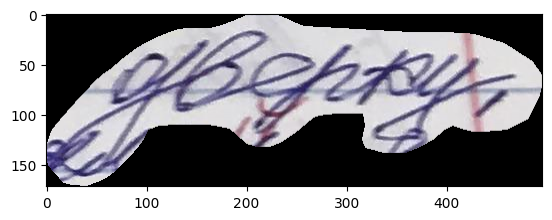

In [12]:
image = plt.imread(os.path.join(train_images, '0.png'))
plt.imshow(image)
plt.show()

In [13]:
len(os.listdir(train_images))

161701

In [14]:
import json

with open('/content/train_segmentation/train_segmentation/annotations.json') as f:
    seg_annotations = json.load(f)

In [15]:
from sklearn.model_selection import train_test_split

val_annot = seg_annotations.copy()
train_annot = seg_annotations.copy()

train_annot['images'], val_annot['images']  = train_test_split(seg_annotations['images'], test_size=0.1, random_state=42)

In [16]:
with open(os.path.join(data_dir, '/content/train_segmentation/train_segmentation/annotations_val.json'), 'w') as outfile:
    json.dump(val_annot, outfile)


with open(os.path.join(data_dir, '/content/train_segmentation/train_segmentationannotations_train.json'), 'w') as outfile:
    json.dump(train_annot, outfile)

# Train mask rcnn

## Train mask-rcnn

In [17]:
import torchvision
from torchvision.models.detection.faster_rcnn import FastRCNNPredictor
from torchvision.models.detection.mask_rcnn import MaskRCNNPredictor


def get_instance_segmentation_model(num_classes = 2):
    # load an instance segmentation model pre-trained on COCO
    model = torchvision.models.detection.maskrcnn_resnet50_fpn(pretrained=True)

    in_features = model.roi_heads.box_predictor.cls_score.in_features
    model.roi_heads.box_predictor = FastRCNNPredictor(in_features, num_classes)

    in_features_mask = model.roi_heads.mask_predictor.conv5_mask.in_channels
    hidden_layer = 256
    model.roi_heads.mask_predictor = MaskRCNNPredictor(in_features_mask,
                                                       hidden_layer,
                                                       num_classes)

    return model

In [18]:
model = get_instance_segmentation_model()
model = model.to(device)


params = [p for p in model.parameters() if p.requires_grad]
optimizer = optim.Adam(params, lr=3e-4)

lr_scheduler = torch.optim.lr_scheduler.StepLR(optimizer,
                                               step_size=20,
                                               gamma=0.5)

Downloading: "https://download.pytorch.org/models/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth" to /root/.cache/torch/hub/checkpoints/maskrcnn_resnet50_fpn_coco-bf2d0c1e.pth
100%|██████████| 170M/170M [00:01<00:00, 152MB/s]


In [19]:
!pip install torch==2.0.1+cu118 torchvision==0.15.2+cu118 torchaudio==2.0.2 --index-url https://download.pytorch.org/whl/cu118
!pip install -U openmim
!mim install "mmcv>=2.0.0rc4,<2.1.0"
!mim install "mmdet>=3.0.0,<3.2.0"

# Проверка
import torch, mmcv, mmdet
print("Torch:", torch.__version__)
print("MMCV:", mmcv.__version__)
print("MMDetection:", mmdet.__version__)

Looking in indexes: https://download.pytorch.org/whl/cu118
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.3/2.3 GB 439.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.1/6.1 MB 111.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.4/4.4 MB 95.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.3/63.3 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 132.3/132.3 kB 12.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for lit: filename=lit-15.0.7-py3-none-any.whl size=89990 sha256=fb86680c981b827cf694f2647bdc9cf3909e716ec516f20eef4cfcd5f7c5abcf
  Stored in directory: /root/.cache/pip/wheels/fc/5d/45/34fe9945d5e45e261134e72284395be36c2d4828af38e2b0fe
Successfully built lit
  Attempting uninstall: triton
    Found existing installation: triton 3.2.0
    Uninstalling triton-3.2.0:
      Successfully uninstalled triton-3.2.0
  Attempting uninstall: torch
    Found existing installation: torch 2.6

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 259.5/259.5 kB 9.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 57.0/57.0 kB 4.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 50.1/50.1 kB 4.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.7/89.7 kB 8.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 449.6/449.6 kB 31.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.7/52.7 kB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 311.5/311.5 kB 26.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.8/62.8 kB 5.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 239.4/239.4 kB 21.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 506.5/506.5 kB 40.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 77.1/77.1 kB 7.7 MB/s eta 0:00:0

Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 74.4/74.4 MB 8.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 46.8/46.8 kB 2.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 452.7/452.7 kB 18.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 256.2/256.2 kB 21.3 MB/s eta 0:00:00
Looking in links: https://download.openmmlab.com/mmcv/dist/cu118/torch2.0.0/index.html
Ignoring mmcv: markers 'extra == "mim"' don't match your environment
Ignoring mmengine: markers 'extra == "mim"' don't match your environment
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 34.4 MB/s eta 0:00:00
  Attempting uninstall: mmdet
    Found existing installation: mmdet 3.3.0
    Uninstalling mmdet-3.3.0:
      Successfully uninstalled mmdet-3.3.0
Torch: 2.6.0+cu124
MMCV: 2.0.1
MMDetection: 3.1.0


In [20]:
# !pip uninstall -y torch torchvision torchaudio triton transformers
# !pip install torch==1.13.1 torchvision==0.15.2 torchaudio==0.13.1
# !pip install transformers==4.41.0

In [21]:
import torch
print(torch.__version__)

2.6.0+cu124


In [22]:
import os
os.environ["TORCHDYNAMO_DISABLE"] = "1"

In [23]:
print(os.listdir("/content/train_recognition/train_recognition"))

['.DS_Store', 'labels.csv', 'images']


In [24]:
from torchvision.datasets import CocoDetection
from torch.utils.data import DataLoader
from torchvision.transforms import functional as TF
import torch
import os

class CocoDataset(torchvision.datasets.CocoDetection):
    def __getitem__(self, idx):
        image, annotations = super().__getitem__(idx)

        boxes, labels, masks = [], [], []
        for ann in annotations:
            bbox = ann["bbox"]
            x, y, w, h = bbox
            boxes.append([x, y, x + w, y + h])
            labels.append(1)  # только один класс "text"
            masks.append(self.coco.annToMask(ann))

        image = TF.to_tensor(image)
        target = {
            "boxes": torch.tensor(boxes, dtype=torch.float32),
            "labels": torch.tensor(labels, dtype=torch.int64),
            "masks": torch.tensor(masks, dtype=torch.uint8),
            "image_id": torch.tensor([idx])
        }

        return image, target

def collate_fn(batch):
    return tuple(zip(*batch))

# Параметры путей
data_root = "/content/train_recognition/train_recognition"
train_dataset = CocoDataset(
    root=os.path.join(data_root, "images"),
    annFile=os.path.join(data_root, "labels.csv")
)

# Разделим датасет (если нет отдельного val)
train_size = int(0.9 * len(train_dataset))
val_size = len(train_dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=2, shuffle=True, collate_fn=collate_fn, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=2, shuffle=False, collate_fn=collate_fn, num_workers=2)

loading annotations into memory...


JSONDecodeError: Expecting value: line 1 column 1 (char 0)

In [ ]:
import torch
from tqdm import tqdm
import matplotlib.pyplot as plt
import torchvision.transforms.functional as F
import numpy as np

def train_model(model, train_loader, val_loader, criterion, optimizer, lr_scheduler, num_epochs, model_name, device='cuda'):
    model.to(device)
    best_val_loss = float('inf')
    history = {'train_loss': [], 'val_loss': []}

    for epoch in range(num_epochs):
        print(f"\nEpoch {epoch}/{num_epochs - 1}")
        print("-" * 20)

        # --- TRAINING ---
        model.train()
        running_loss = 0.0
        loss_log = {}

        for images, targets in tqdm(train_loader, desc="Train", leave=False):
            images = [img.to(device) for img in images]
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

            loss_dict = model(images, targets)
            losses = sum(loss for loss in loss_dict.values())

            optimizer.zero_grad()
            losses.backward()
            optimizer.step()

            running_loss += losses.item()

            for k, v in loss_dict.items():
                loss_log[k] = loss_log.get(k, 0) + v.item()

        avg_train_loss = running_loss / len(train_loader)
        history['train_loss'].append(avg_train_loss)

        print("train Loss:", {k: round(v / len(train_loader), 6) for k, v in loss_log.items()})

        # --- VALIDATION ---
        model.eval()
        val_loss = 0.0
        val_log = {}

        with torch.no_grad():
            for images, targets in tqdm(val_loader, desc="Val", leave=False):
                images = [img.to(device) for img in images]
                targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

                loss_dict = model(images, targets)
                losses = sum(loss for loss in loss_dict.values())

                val_loss += losses.item()
                for k, v in loss_dict.items():
                    val_log[k] = val_log.get(k, 0) + v.item()

        avg_val_loss = val_loss / len(val_loader)
        history['val_loss'].append(avg_val_loss)

        print("test Loss:", {k: round(v / len(val_loader), 6) for k, v in val_log.items()})

        if avg_val_loss < best_val_loss:
            best_val_loss = avg_val_loss
            print(f"updated best loss, now it {best_val_loss:.10f}")
            torch.save(model.state_dict(), model_name)

            # Визуализация результата на одной картинке
            sample_img = images[0].cpu()
            sample_target = targets[0]
            sample_output = model([sample_img.to(device)])[0]

            plt.figure(figsize=(12, 6))
            plt.subplot(1, 2, 1)
            plt.imshow(F.to_pil_image(sample_img))
            plt.axis("off")
            plt.subplot(1, 2, 2)

            mask = torch.zeros_like(sample_img[0])
            for m in sample_output['masks']:
                mask = torch.maximum(mask, (m[0] > 0.5).cpu())

            plt.imshow(mask, cmap='rainbow', alpha=0.8)
            plt.axis("off")
            plt.show()

        lr_scheduler.step()

    return history

In [ ]:

history = train_model(model, train_loader, val_loader, None, optimizer, lr_scheduler, 30, 'mask_rcnn_small_2')

# Generate poligons

### Get masks

In [ ]:
sys.path.append('mmdetection')

import mmdet
import mmcv
# from mmcv.ops import get_compiling_cuda_version, get_compiler_version

from mmdet.datasets import build_dataset
from mmdet.models import build_detector
from mmdet.apis import train_detector
# from mmcv import Config
from mmdet.apis import init_detector, inference_detector, show_result_pyplot, set_random_seed

In [ ]:
class SegmentationModel:
  def __init__(self, model_path, cfg):
    with open('labels.txt', 'w') as f:
      f.write('text')
    self.cfg = cfg
    self.cfg.load_from = model_path
    self.model = init_detector(self.cfg, model_path, device=device)
    self.model.CLASSES = ['text']
    self.model.cfg = self.cfg
    self.threshold = 0.3

  def eval(self):
    return self

  def __call__(self, batch):
    result = mmdet.apis.inference.inference_detector(self.model, batch)
    output = []
    for img in result:
      out_img = []
      for box in img[0]:
        out = []
        #print(len(box))
        left, top, right, bottom, c = box
        if c > self.threshold:
          out.append([[left, top]])
          out.append([[right, top]])
          out.append([[right, bottom]])
          out.append([[left, bottom]])
          out_img.append(out)
      output.append(out_img)
    return np.array(output).astype(int)

In [ ]:
import config
importlib.reload(config)

seg_model = SegmentationModel('/content/drive/MyDrive/НТИ ИИ /team/semeka_models/epoch_21.pth',
                              config.cfg)

In [ ]:
image = cv2.imread('/content/train_segmentation/images/0_0_eng.jpg')
# image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

contours = seg_model([image])

for contour in contours[0]:
    cv2.drawContours(image, np.array([contour.astype(int)]), -1, (0, 255, 0), 2)


plt.figure(figsize=(15,15))
plt.imshow(image)
plt.show()

# Loading TrOcr

In [ ]:
def plot_images(images_for_show):
  """Строит изображение на одном графике"""
  fig = plt.figure(figsize=(16, 16))

  columns = len(images_for_show)
  rows = 1
  for i in range(1, columns*rows +1):
    fig.add_subplot(rows, columns, i)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(np.clip(images_for_show[i - 1], 0, 1))

  fig.subplots_adjust(wspace=0.1, hspace=0)
  plt.show()

In [ ]:
class AlbuPadding(A.DualTransform):
    def __init__(self, always_apply=False, p=0.5):
        super(AlbuPadding, self).__init__(always_apply, p)

    def apply(self, image, **params):
        zeros = np.zeros((128, 384, 3))
        image = np.concatenate([zeros, image, zeros], axis=0)
        return image.astype(np.uint8)

In [ ]:
from albumentations.pytorch.transforms import ToTensor
from transformers import AutoFeatureExtractor, XLMRobertaTokenizer, VisionEncoderDecoderModel, RobertaTokenizer

class TrOcrModel:
  def __init__(self, model_path, padding=True):
      self.model = VisionEncoderDecoderModel.from_pretrained(model_path).to(device)
      self.model.eval()

      self.feature_extractor = AutoFeatureExtractor.from_pretrained('microsoft/trocr-small-handwritten')
      self.tokenizer = XLMRobertaTokenizer.from_pretrained('microsoft/trocr-small-handwritten')

      if padding:
        self.transforms = A.Compose([
                A.Resize(128, 384),
                AlbuPadding(always_apply=True),
            ])
      else:
        self.transforms = A.Compose([
                A.Resize(384, 384),
            ])

  def image_preprocess(self, image):
      image = self.transforms(image=image)['image']
      pixel_values = self.feature_extractor(image, return_tensors="pt").pixel_values
      return pixel_values

  def predict_batch(self, images):
      batch = torch.concat([self.image_preprocess(image) for image in images], axis=0).to(device)
      outputs = self.model.generate(batch)
      return [self.tokenizer.decode(pred.cpu().numpy(), skip_special_tokens=True) for pred in outputs]

  def __call__(self, image):
      pred = self.model.generate(self.image_preprocess(image).to(device))
      return self.tokenizer.decode(pred[0].cpu().numpy(), skip_special_tokens=True)

In [ ]:
text_model = TrOcrModel("/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_small_aug_nti2data")

In [ ]:
image = cv2.imread(os.path.join(train_images, '0.png'))
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
plt.imshow(image)
plt.show()

In [ ]:
text_model(image)

In [ ]:
text_model.predict_batch([image, image])

# Making predict

In [ ]:
from PIL import ImageFont, ImageDraw, Image

In [ ]:
def crop_img_by_polygon(img, polygon):
    # https://stackoverflow.com/questions/48301186/cropping-concave-polygon-from-image-using-opencv-python
    pts = np.array(polygon)
    rect = cv2.boundingRect(pts)
    x,y,w,h = rect
    croped = img[y:y+h, x:x+w]
    pts = pts - pts.min(axis=0)
    mask = np.zeros(croped.shape[:2], np.uint8)
    cv2.drawContours(mask, [pts], -1, (255, 255, 255), -1, cv2.LINE_AA)
    dst = cv2.bitwise_and(croped, croped, mask=mask)
    return dst

In [ ]:
def get_image_visualization(img, pred_data, fontpath, font_koef=50):
    img = img.copy()
    h, w = img.shape[:2]
    font = ImageFont.truetype(fontpath, int(h/font_koef))
    empty_img = Image.new('RGB', (w, h), (255, 255, 255))
    draw = ImageDraw.Draw(empty_img)

    for prediction in pred_data['predictions']:
        polygon = prediction['polygon']
        pred_text = prediction['text']
        cv2.drawContours(img, np.array([polygon]), -1, (0, 255, 0), 2)
        x, y, w, h = cv2.boundingRect(np.array([polygon]))
        draw.text((x, y), pred_text, fill=0, font=font)
        # print(pred_text, x, y)

    vis_img = np.array(empty_img)
    vis = np.concatenate((img, vis_img), axis=1)
    return vis

In [ ]:
def get_polygon_for_answer(polygon, croped):
    pts = np.array(polygon)
    rect = cv2.boundingRect(pts)
    x1,y1,w,h = rect
    mid_x = x1 + w // 2
    mid_y = y1 + h // 2

    best = 1e9
    for i in range(h):
      now = abs((croped[:i, :] != [0, 0, 0]).sum() - (croped[i:, :] != [0, 0, 0]).sum())
      if now < best:
        best = now
        mid_y = i + y1

    x1 = mid_x - w // 5
    x2 = mid_x + w // 5
    # return [(mid_y, x1), (mid_y + 5, x1), (mid_y + 5, x2), (mid_y, x2)]
    return [(x1, mid_y), (x1, mid_y + 1), (x2, mid_y + 1), (x2, mid_y)]

In [ ]:
def get_classifier_model():

  model = models.resnet50(pretrained=True)
  model.fc = nn.Sequential(
      nn.Linear(2048, 256),
      nn.ReLU(),
      nn.Linear(256, 2)
  )
  return model

In [ ]:
with open(os.path.join(data_dir, 'train_segmentation/annotations.json'), 'r') as f:
    annotations = json.load(f)

def get_image_cer(image_name):
  img = cv2.imread('data/train_segmentation/images/' + image_name)
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pred_data = {}
  pred_data[image_name] = pipeline_model(img)
  with open('prediction.json', "w") as f:
    json.dump(pred_data, f)

  now = annotations.copy()
  for el in annotations['images']:
    if el['file_name'] == image_name:
      now['images'] = [el]
      break


  with open(os.path.join('annotations_now.json'), 'w') as outfile:
      json.dump(now, outfile)
  print('predict is ready')

  print(os.popen('python3 data/evaluate.py --ref_path annotations_now.json --pred_path prediction.json').read())

In [ ]:
np.argsort([0, 3, 2])

In [ ]:
import config

class PiepleinePredictor:
    def __init__(self, segm_model_path, ru_ocr_model_path, en_ocr_model_path, classifier_model_path):
        # self.seg_model = SEGMpredictor(segm_model_path)
        self.seg_model = SegmentationModel(segm_model_path, config.cfg)

        self.text_model = {'ru': TrOcrModel(ru_ocr_model_path),
                           'en': TrOcrModel(en_ocr_model_path)}
        self.batch_size = 8
        self.transforms = A.RandomScale(scale_limit=(-0.5, -0.5), p=1)

        self.classifier_model = torch.load(classifier_model_path, map_location=device)
        self.classifier_predicts = 25
        self.classifier_transforms = A.Compose([
                  A.Resize(128, 384),
                  ToTensor()
              ])

    def predict_language(self, images):
        p = np.argsort([el.shape[1] for el in images])
        batch = []
        for idx in p[-self.classifier_predicts:]:
          batch.append(self.classifier_transforms(image=images[idx])['image'])

        batch = torch.stack(batch).to(device)
        preds = self.classifier_model(batch)
        preds = torch.argmax(preds, dim=1)
        # plot_images([torch.moveaxis(el, 0, -1).detach().cpu().numpy() for el in batch[:10]])
        # print(preds[:10])
        res = preds.sum() > len(preds) / 2
        return 'ru' if res else 'en'

    def __call__(self, img, return_only_language=False):
        img = img.copy()
        # img = self.transforms(image=img)['image']
        with torch.no_grad():
          output = {'predictions': []}
          bgr = cv2.cvtColor(img.copy(), cv2.COLOR_RGB2BGR)
          contours = self.seg_model([bgr])[0]
          images = []
          not_none_contours = []
          for contour in contours:
              if contour is not None:
                  crop = crop_img_by_polygon(img, contour)
                  images.append(crop)
                  not_none_contours.append(contour)

          language = self.predict_language(images)
          if return_only_language:
            return language

          predicted_text = []
          for i in range(0, len(images), self.batch_size):
            predicted_text += self.text_model[language].predict_batch(images[i:i + self.batch_size])


          # for img, text in zip(images[:30], predicted_text[:30]):
          #   plt.imshow(img)
          #   plt.title(text)
          #   plt.show()

          for pred_text, contour, crop in zip(predicted_text, not_none_contours, images):
            output['predictions'].append({
                              # 'polygon': [[int(i[0][0] * 2), int(i[0][1] * 2)] for i in contour],
                              # 'polygon': [[int(i[0][0]), int(i[0][1])] for i in contour],
                              'polygon': get_polygon_for_answer(contour, crop),
                              'text': pred_text
                            })
        return output

In [ ]:
pipeline_model = PiepleinePredictor(
                                    '/content/drive/MyDrive/НТИ ИИ /team/semeka_models/epoch_21.pth',
                                    # '/content/drive/MyDrive/НТИ ИИ /team/sergey_models/mask_rcnn_small',
                                    "/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_small",
                                    "/content/drive/MyDrive/НТИ ИИ /team/sergey_models/tr_ocr_best_eng_padding",
                                    "/content/drive/MyDrive/НТИ ИИ /team/sergey_models/language_classifier"
                                    ) #_aug_nti2data

In [ ]:
get_image_cer('0_0_eng.jpg')

In [ ]:
get_image_cer('100_0.JPG')

In [ ]:
get_image_cer('6_1_eng.jpg')

In [ ]:
path = 'data/train_segmentation/images'

sum = 0
right = 0
for image_name in tqdm(os.listdir(path)[:]):
  real = 'en' if 'eng' in image_name else 'ru'
  img = cv2.imread(os.path.join(path, image_name))
  img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
  pred = pipeline_model(img, True)
  sum += 1
  right += pred == real
  if pred != real:
    print(image_name, real)

print()
print(right, sum)

In [ ]:
img = cv2.imread('data/train_segmentation/images/105_0.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

In [ ]:
output = pipeline_model(img)
vis = get_image_visualization(img, output, os.path.join(data_dir, 'font.otf'))

plt.figure(figsize=(20, 20))
plt.imshow(vis)
plt.show()

In [ ]:
img = cv2.imread('data/train_segmentation/images/105_0.JPG')
img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
img = A.RandomScale(scale_limit=(-0.5, -0.5), p=1)(image=img)['image']

plt.figure(figsize=(15, 15))
plt.imshow(img)

# Save predictions from dataset

In [ ]:
# Путь к json'у с разметкой
DATA_JSON_PATH = 'data/train_segmentation/annotations_val.json'

# Папка с картинками тетрадей
IMAGE_ROOT = 'data/train_segmentation/images/'

# Файл для сохранения предсказаний пайплайна. Один json
SAVE_PATH = os.path.join(project_dir, 'prediction.json')

In [ ]:
with open(DATA_JSON_PATH, 'r') as f:
    data = json.load(f)

pred_data = {}

In [ ]:
for data_img in tqdm(data['images']):
    img_name = data_img['file_name']
    image = cv2.imread(os.path.join(IMAGE_ROOT, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pred_data[img_name] = pipeline_model(image)

In [ ]:
for data_img in tqdm(data['images']):
    img_name = data_img['file_name']
    image = cv2.imread(os.path.join(IMAGE_ROOT, img_name))
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    pred_data[img_name] = pipeline_model(image)

In [ ]:
with open('prediction.json', "w") as f:
    json.dump(pred_data, f)

In [ ]:
#small
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

In [ ]:
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

In [ ]:
# mask_rcnn_small + en_ocr_padding + classifier not regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

In [ ]:
# mask_rcnn_small + en_ocr_padding + classifier regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

In [ ]:
# mask_rcnn_small + en_ocr_padding + classifier not regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json

In [ ]:
# detectoRS + en_ocr + classifier not regression
!python3 data/evaluate.py --ref_path data/train_segmentation/annotations_val.json --pred_path prediction.json